In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**Data processing**


In [2]:
# Changing the path to the root of the repository

if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

Changed working directory to: c:\Users\piopi\Desktop\Projet_EI_ST4\Forecast-of-Electricity-Consumption


In [3]:
# Load raw data
acorn_details = pd.read_csv('data/00_raw/acorn_details.csv', encoding='ISO-8859-1')
temperatures = pd.read_csv('data/00_raw/temperatures.csv', sep=';', decimal=',', encoding='utf-8')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
weather_hourly = pd.read_csv('data/00_raw/weather_hourly_darksky.csv')

# Load processed data from parquet
group_4_daily_predict = pd.read_parquet('data/02_processed/parquet/group_4_daily_predict.parquet')
group_4_half_hourly_predict = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly_predict.parquet')
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
group_4_half_hourly = pd.read_parquet('data/02_processed/parquet/group_4_half_hourly.parquet')

In [4]:
# Fixing Datetime formats
temperatures['DateTime'] = pd.to_datetime(temperatures['DateTime'], format='mixed')
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')

# Convert all datetime-like columns in weather_daily to datetime format
datetime_columns = ['temperatureMaxTime', 'temperatureMinTime', 'apparentTemperatureMinTime', 
                   'apparentTemperatureHighTime', 'time', 'sunsetTime', 'sunriseTime', 
                   'temperatureHighTime', 'uvIndexTime', 'temperatureLowTime', 
                   'apparentTemperatureMaxTime', 'apparentTemperatureLowTime']

for col in datetime_columns:
    weather_daily[col] = pd.to_datetime(weather_daily[col])

**Daily energy consumption analysis**

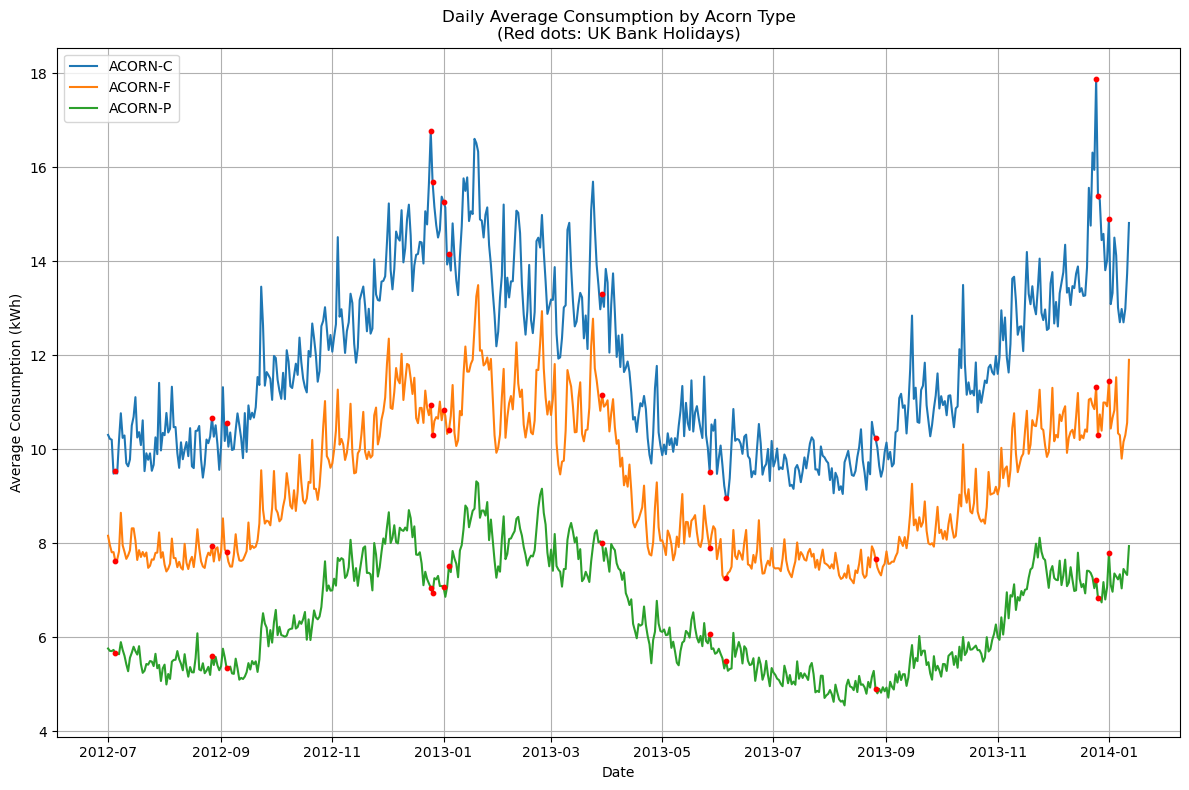

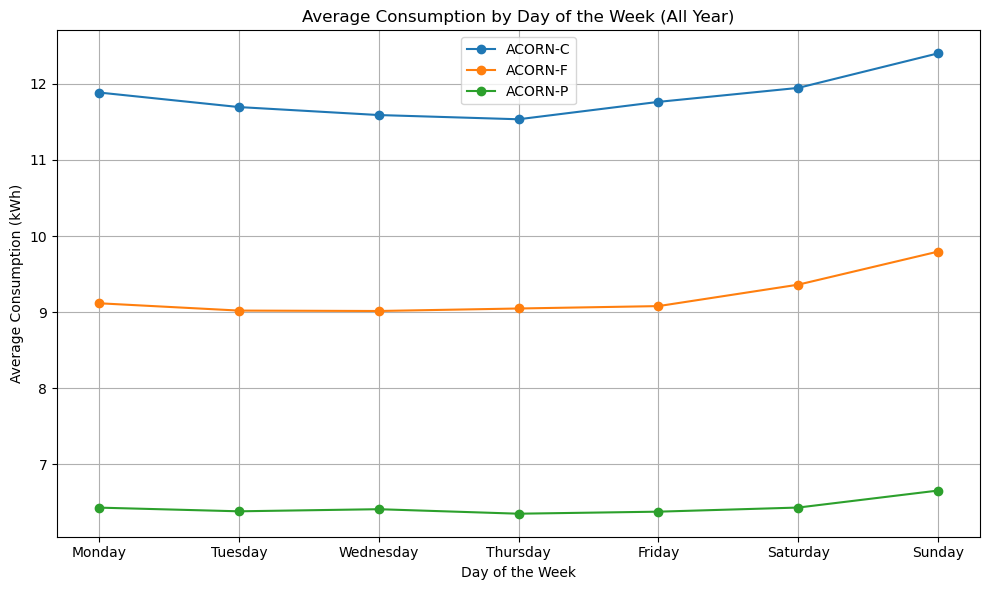

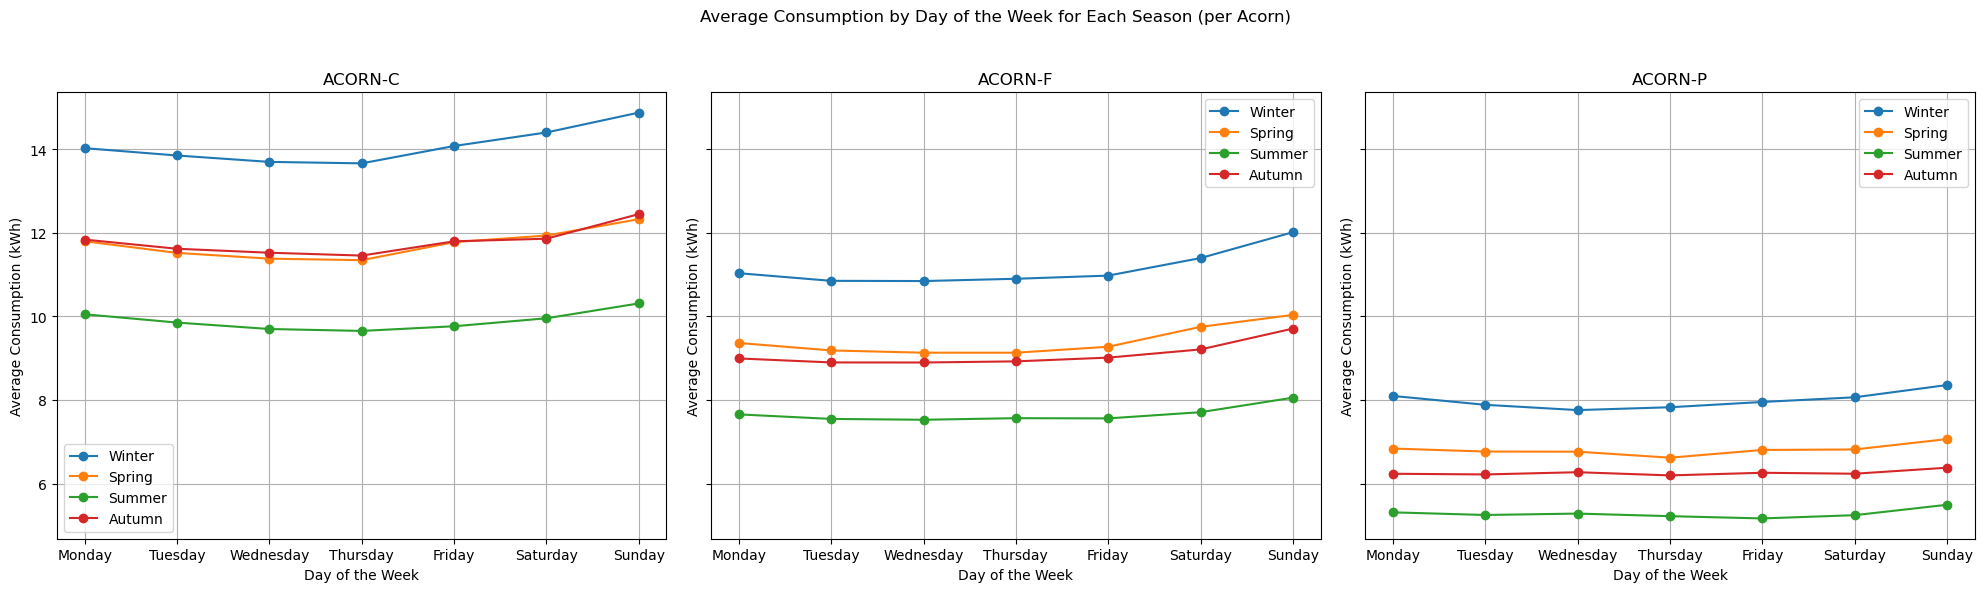

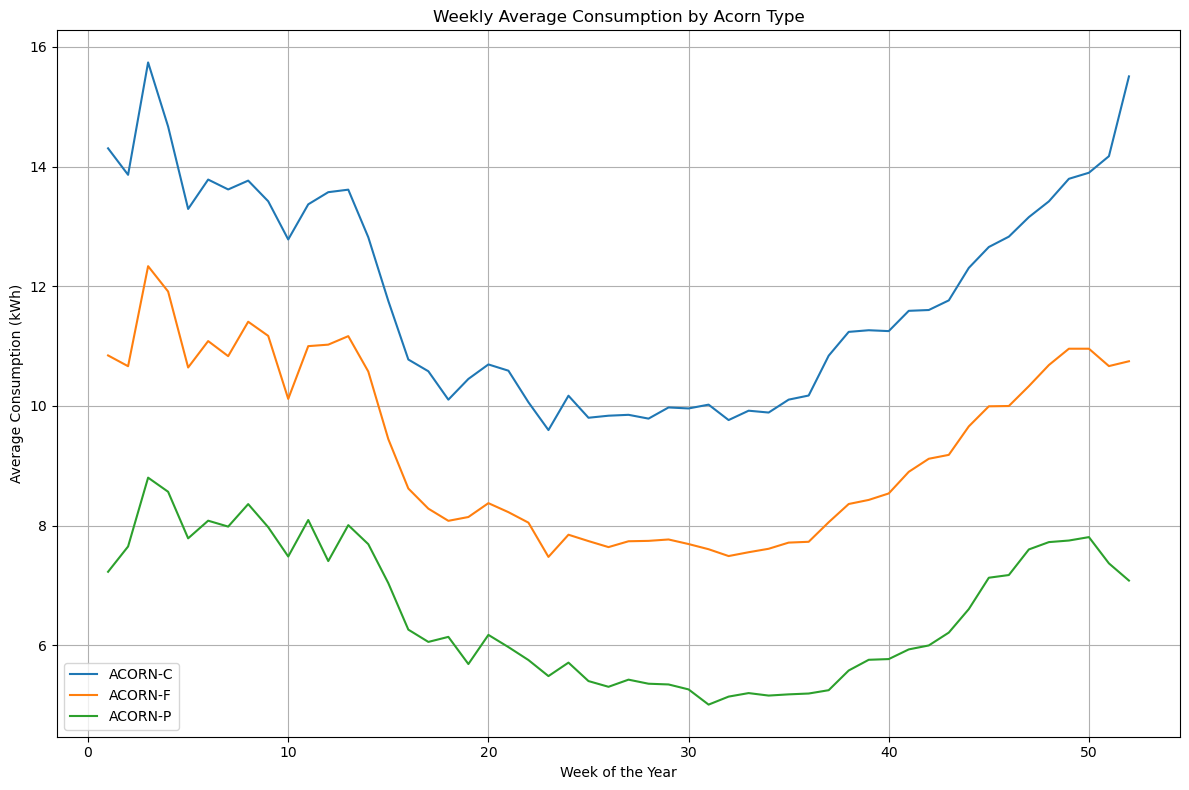

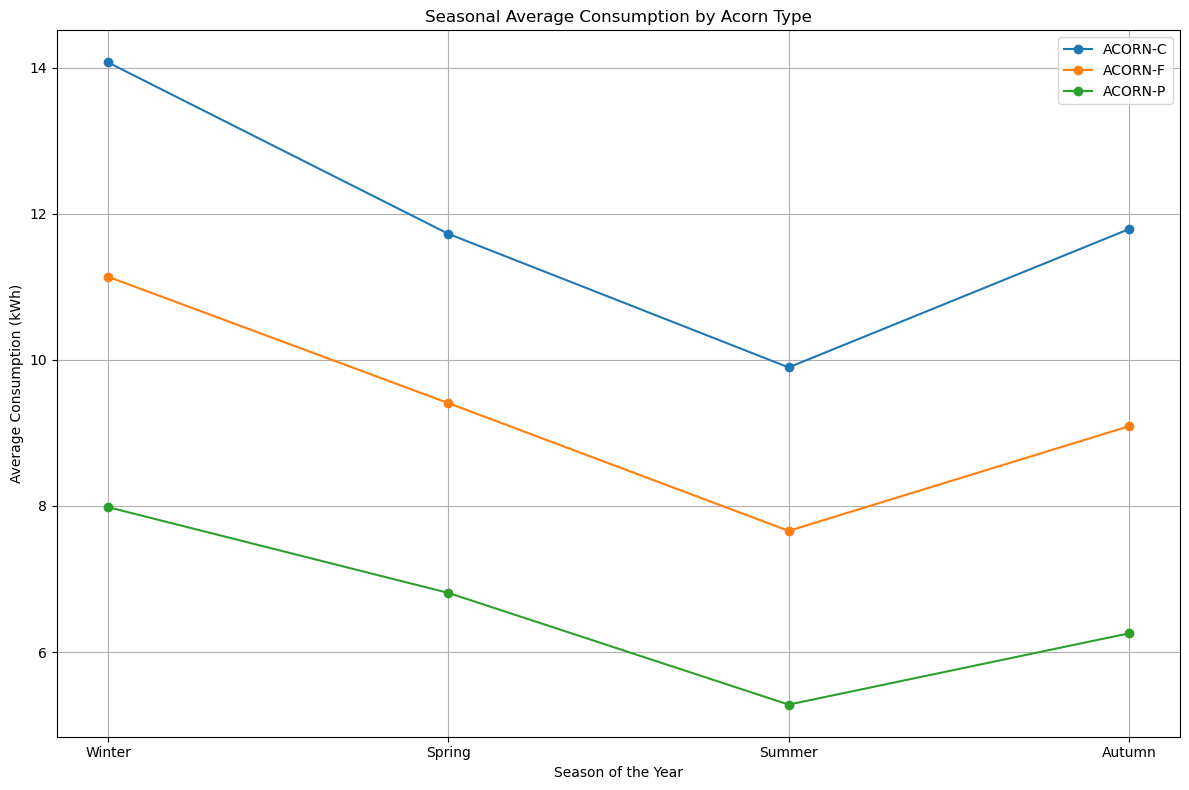

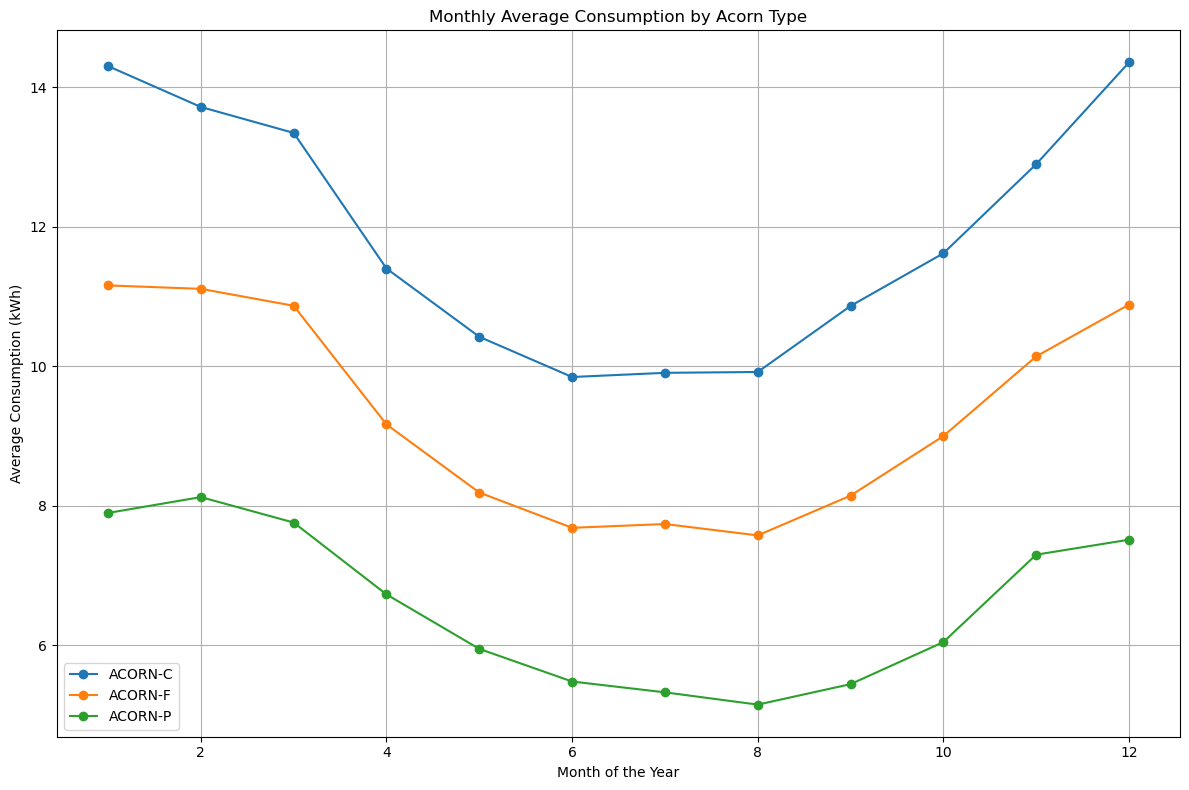

In [5]:
# Renaming data for easy access:
daily = group_4_daily.copy()
half_hourly = group_4_half_hourly.copy()
acorn_types = ['ACORN-C', 'ACORN-F', 'ACORN-P']

# Obtaining the daily average consumption dictionary
daily_avg_consumption = {}
for acorn in acorn_types:
    df = daily[daily['Acorn'] == acorn][['Date', 'Conso_kWh']].reset_index(drop=True)
    daily_avg_consumption[acorn] = df

# Prepare bank_holiday_dates as a DatetimeArray
bank_holiday_dates = uk_bank_holidays['Bank holidays'].values

# Prepare acorn_data dictionary for each Acorn type
acorn_data = {}
for acorn in acorn_types:
    acorn_data[acorn] = daily[daily['Acorn'] == acorn].reset_index(drop=True)

# Plotting the daily average consumption for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, daily_avg in daily_avg_consumption.items():
    plt.plot(daily_avg['Date'], daily_avg['Conso_kWh'], label=acorn)
    # Plot bank holidays for this acorn
    bh_dates = []
    bh_conso = []
    for date in sorted(bank_holiday_dates):
        # Only plot if the date exists for this acorn
        if date in daily_avg['Date'].values:
            value = daily_avg.loc[daily_avg['Date'] == date, 'Conso_kWh'].values
            if len(value) > 0:
                bh_dates.append(date)
                bh_conso.append(value[0])
    plt.scatter(bh_dates, bh_conso, color='red', s=10, zorder=5)
plt.title('Daily Average Consumption by Acorn Type\n(Red dots: UK Bank Holidays)')
plt.xlabel('Date')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt


# Daily average consumption by day of the week for each Acorn type
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg_by_weekday = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Weekday'] = data['Date'].dt.dayofweek
    avg_by_weekday = data.groupby('Weekday', as_index=False)['Conso_kWh'].mean()
    avg_by_weekday['Day'] = avg_by_weekday['Weekday'].map(dict(enumerate(day_names)))
    daily_avg_by_weekday[acorn] = avg_by_weekday

plt.figure(figsize=(10, 6))
for acorn, avg_by_weekday in daily_avg_by_weekday.items():
    plt.plot(avg_by_weekday['Day'], avg_by_weekday['Conso_kWh'], label=acorn, marker='o')
plt.title('Average Consumption by Day of the Week (All Year)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Define seasons for further analysis
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Plot daily average by day of the week, separated by season, for each Acorn type in a single row
fig, axes = plt.subplots(1, len(acorn_data), figsize=(20, 6), sharey=True)
for ax, (acorn, data) in zip(axes, acorn_data.items()):
    data = data.copy()
    data['Season'] = pd.cut(data['Date'].dt.month, bins=[0, 3, 6, 9, 12], labels=seasons, right=False)
    data['Weekday'] = data['Date'].dt.dayofweek
    for season in seasons:
        season_data = data[data['Season'] == season]
        avg_by_weekday = season_data.groupby('Weekday', as_index=False)['Conso_kWh'].mean()
        avg_by_weekday['Day'] = avg_by_weekday['Weekday'].map(dict(enumerate(day_names)))
        ax.plot(avg_by_weekday['Day'], avg_by_weekday['Conso_kWh'], label=season, marker='o')
    ax.set_title(f'{acorn}')
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Average Consumption (kWh)')
    ax.legend()
    ax.grid()
fig.suptitle('Average Consumption by Day of the Week for Each Season (per Acorn)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Obtaining the weekly average consumption for each Acorn type:
weekly_avg_consumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Week'] = data['Date'].dt.isocalendar().week
    weekly_avg = data.groupby('Week', as_index=False)['Conso_kWh'].mean()
    weekly_avg_consumption[acorn] = weekly_avg

# Plotting the weekly average consumption for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, weekly_avg in weekly_avg_consumption.items():
    plt.plot(weekly_avg['Week'], weekly_avg['Conso_kWh'], label=acorn)
plt.title('Weekly Average Consumption by Acorn Type')
plt.xlabel('Week of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Obtaining the average consumption per season for each Acorn type:
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_avg_consumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Season'] = pd.cut(data['Date'].dt.month, bins=[0, 3, 6, 9, 12], 
                            labels=seasons, right=False)
    seasonal_avg = data.groupby('Season', as_index=False, observed=False)['Conso_kWh'].mean()
    seasonal_avg_consumption[acorn] = seasonal_avg

# Plotting the average consumption per season for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, seasonal_avg in seasonal_avg_consumption.items():
    plt.plot(seasonal_avg['Season'], seasonal_avg['Conso_kWh'], label=acorn, marker='o')
plt.title('Seasonal Average Consumption by Acorn Type')
plt.xlabel('Season of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Obtaining the average consumption per month for each Acorn type:
monthly_avg_consumption = {}
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Month'] = data['Date'].dt.month
    monthly_avg = data.groupby('Month', as_index=False)['Conso_kWh'].mean()
    monthly_avg_consumption[acorn] = monthly_avg

# Plotting the average consumption per month for each Acorn type:
plt.figure(figsize=(12, 8))
for acorn, monthly_avg in monthly_avg_consumption.items():
    plt.plot(monthly_avg['Month'], monthly_avg['Conso_kWh'], label=acorn, marker='o')
plt.title('Monthly Average Consumption by Acorn Type')
plt.xlabel('Month of the Year')
plt.ylabel('Average Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()   

In [6]:
acorn_types = list(acorn_data.keys())
results = {}

# Weekend effect
weekend_table = []
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Weekday'] = data['Date'].dt.dayofweek
    avg_all = data['Conso_kWh'].mean()
    avg_weekend = data[data['Weekday'] >= 5]['Conso_kWh'].mean()
    avg_weekday = data[data['Weekday'] < 5]['Conso_kWh'].mean()
    weekend_table.append([
        acorn,
        avg_weekday,
        avg_weekend,
        avg_weekend - avg_weekday,
        100 * (avg_weekend - avg_weekday) / avg_weekday
    ])

weekend_df = pd.DataFrame(
    weekend_table,
    columns=[
        'Acorn',
        'Weekday Avg (kWh)',
        'Weekend Avg (kWh)',
        'Abs Increase (kWh)',
        '% Increase'
    ]
)

# Sunday vs Average Day
sunday_table = []
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Weekday'] = data['Date'].dt.dayofweek
    avg_all = data['Conso_kWh'].mean()
    avg_sunday = data[data['Weekday'] == 6]['Conso_kWh'].mean()
    sunday_table.append([
        acorn,
        avg_sunday,
        avg_all,
        avg_sunday - avg_all,
        100 * (avg_sunday - avg_all) / avg_all
    ])

sunday_df = pd.DataFrame(
    sunday_table,
    columns=[
        'Acorn',
        'Sunday Avg (kWh)',
        'Avg Day (kWh)',
        'Abs Increase (kWh)',
        '% Increase'
    ]
)

# Seasonal variation
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
season_table = []
for acorn, data in acorn_data.items():
    data = data.copy()
    data['Season'] = pd.cut(data['Date'].dt.month, bins=[0, 3, 6, 9, 12], labels=season_names, right=False)
    season_means = data.groupby('Season', observed=False)['Conso_kWh'].mean()
    row = [acorn] + [season_means.get(season, np.nan) for season in season_names]
    season_table.append(row)
season_df = pd.DataFrame(
    season_table,
    columns=['Acorn'] + [f'{s} Avg (kWh)' for s in season_names]
)

# Holidays effect
holiday_table = []
for acorn, data in acorn_data.items():
    data = data.copy()
    data['IsHoliday'] = data['Date'].isin(bank_holiday_dates)
    avg_holiday = data[data['IsHoliday']]['Conso_kWh'].mean()
    avg_nonholiday = data[~data['IsHoliday']]['Conso_kWh'].mean()
    holiday_table.append([
        acorn,
        avg_nonholiday,
        avg_holiday,
        avg_holiday - avg_nonholiday,
        100 * (avg_holiday - avg_nonholiday) / avg_nonholiday
    ])
holiday_df = pd.DataFrame(
    holiday_table,
    columns=[
        'Acorn',
        'Non-Holiday Avg (kWh)',
        'Holiday Avg (kWh)',
        'Abs Increase (kWh)',
        '% Increase'
    ]
)

# Display tables
print("Weekend vs Weekday Consumption:")
display(weekend_df.round(2))
print("\nSunday vs Average Day Consumption:")
display(sunday_df.round(2))
print("\nSeasonal Average Consumption:")
display(season_df.round(2))
print("\nHoliday vs Non-Holiday Consumption:")
display(holiday_df.round(2))

Weekend vs Weekday Consumption:


,Acorn,Weekday Avg (kWh),Weekend Avg (kWh),Abs Increase (kWh),% Increase
0,ACORN-C,11.69,12.17,0.48,4.11
1,ACORN-F,9.06,9.58,0.52,5.78
2,ACORN-P,6.39,6.55,0.15,2.40



Sunday vs Average Day Consumption:


,Acorn,Sunday Avg (kWh),Avg Day (kWh),Abs Increase (kWh),% Increase
0,ACORN-C,12.40,11.83,0.57,4.80
1,ACORN-F,9.80,9.21,0.59,6.40
2,ACORN-P,6.66,6.44,0.22,3.42



Seasonal Average Consumption:


,Acorn,Winter Avg (kWh),Spring Avg (kWh),Summer Avg (kWh),Autumn Avg (kWh)
0,ACORN-C,14.07,11.72,9.90,11.79
1,ACORN-F,11.14,9.41,7.66,9.09
2,ACORN-P,7.98,6.81,5.28,6.26



Holiday vs Non-Holiday Consumption:


,Acorn,Non-Holiday Avg (kWh),Holiday Avg (kWh),Abs Increase (kWh),% Increase
0,ACORN-C,11.80,13.06,1.26,10.69
1,ACORN-F,9.20,9.49,0.29,3.20
2,ACORN-P,6.43,6.53,0.10,1.56


### **Remarks:**
- More average consumption in the weekends, with the most relative increase for Acorn-F of 5,8%, followed by Acorn-C of 4,11% and Acorn-P of 2,4%. 
- Peak average consumption is on Sundays for all acorns, with relative increases similar to the average weekend change. 
- Bank holidays show local increases in consumption for the three groups, but are only notorious in Acorn-C, with an increase of 10,7%, compared to that of 3,2% and 1,6% for Acorns-F and P, respectively. 
- For all acorns, the highest average consumption is on winter, while the lowest is on summer. The average consumption on spring is slightly higher than on autumn.
